In [2]:
import numpy as np
import scanpy as sc
import scipy
from scipy.sparse import csr_matrix
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
from composition_stats import clr
import anndata as ad
from muon import prot as pt

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDepr

In [ ]:
!aws s3 cp h5ads/lib_1.h5ad s3://ucsf-genomics-prod-project-data// --sse-kms-key-id alias/managed-s3-key --sse aws:kms


In [6]:
def over_input(dataframe, hashtag_names): #Hashtag names must be a list
    df_hash = pd.DataFrame(columns=dataframe.var_names, index=dataframe.obs.index)
    res = np.array(dataframe.X.todense()) # this step is very wasteful
    # it makes no difference, but hashsolo says to do all QC before running it, move things up 
    clr(np.array(dataframe.X.todense()) + 1)#clr transform the hto, doesn't this transform everything? Yes!
    df_hash.iloc[:,:] = res
    dataframe.obs = df_hash.loc[:, hashtag_names]
    for i in hashtag_names: 
        dataframe.obs[i]=dataframe.obs[i].astype(float).astype(np.int64)
    return dataframe

def rna_qc_graphs(adata):
    # mitochondrial genes
    adata.var['mt'] = adata.var_names.str.startswith('MT-') 
    # ribosomal genes
    adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
    # hemoglobin genes.
    adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)
    # view graphs for parameter inputs later
    sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, multi_panel=True)
    
def rna_qc_filter(adata): #(min_genes, min_cells, pct_counts_mt, pct_counts_ribo):
    adata.layers["counts"] = adata.X.copy()
    # mitochondrial genes
    sc.pp.filter_genes(adata, min_counts=1)
    adata.var['mt'] = adata.var_names.str.startswith('MT-') 
    # ribosomal genes
    adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
    # hemoglobin genes.
    adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)
    # this part depends highly on library prep used 
#     sc.pp.filter_cells(adata, min_genes=200)
#     sc.pp.filter_genes(adata, min_cells=3)
    # depends highly on the distribution of data, only thing vaguely reliable between notebooks I've seen
    # filter for percent mito
    adata = adata[adata.obs['pct_counts_mt'] < 20, :]
    # filter for percent ribo > 0.05
    adata = adata[adata.obs['pct_counts_ribo'] > 5, :]
    # still need to apply normalization
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    # further removal? -- seems to be overly specific
#     mito_genes = adata.var_names.str.startswith('MT-')
#     hb_genes = adata.var_names.str.contains('^HB[^(P)]')
#     remove = np.add(mito_genes, malat1)
#     remove = np.add(remove, hb_genes)
#     keep = np.invert(remove)
#     adata = adata[:,keep]
    return adata
def protein_qc_filter(adata):
    # copy raw?
    adata.layers["counts"] = adata.X.copy()
    # apply normalization
    pt.pp.clr(adata)
    sc.pp.log1p(adata)
    return adata

def batch_correction(ls_of_adatas, labels):
    # concat ls_of_adatas
    full_adata = ad.concat([pbmc[inds] for inds in groups.values()], merge="same") # not tested yet
    # add labels for each batch
    full_adata.obs["batch"] = labels
    sce.pp.harmony_integrate(full_adata, 'batch') 
    return full_adata
    
def get_leiden(adata, name):
    sc.pp.pca(adata, n_comps=20)
    sc.pp.neighbors(adata, n_neighbors=30)  # why can't we just work with the default neighbors?
    sc.tl.leiden(adata, key_added=name+"_leiden")
    
def get_vis(rna, protein):
    rna.obsm["protein"] = protein.to_df()
    rna.obsm["protein_umap"] = protein.obsm["X_umap"]
    rna.obs["protein_leiden"] = protein.obs["protein_leiden"]
    rna.obsp["rna_connectivities"] = rna.obsp["connectivities"].copy()
    rna.obsp["protein_connectivities"] = protein.obsp["protein_connectivities"]
    sc.tl.umap(rna)
    sc.pl.umap(rna, color=["rna_leiden", "protein_leiden"], size=10)
    sc.pl.embedding(rna, basis="protein_umap", color=["rna_leiden", "protein_leiden"], size=10)
    
    
hashtag_to_thaw = {
    "TotalSeq-C0251 anti-human Hashtag 1 Antibody" : "M-A3-Unsti",
    "TotalSeq-C0255 anti-human Hashtag 5 Antibody" : "U-A3-Unsti", 
    "TotalSeq-C0259 anti-human Hashtag 9 Antibody" : "Z-A3-Unsti",  
    "TotalSeq-C0253 anti-human Hashtag 3 Antibody" : "M-A3-6th",    
    "TotalSeq-C0254 anti-human Hashtag 4 Antibody" : "M-A3-9th",  
    "TotalSeq-C0257 anti-human Hashtag 7 Antibody" : "U-A3-7th",
    "TotalSeq-C0260 anti-human Hashtag 10 Antibody": "Z-A3-1st",
    "TotalSeq-C0252 anti-human Hashtag 2 Antibody" : "M-A3-3rd",
    "TotalSeq-C0256 anti-human Hashtag 6 Antibody" : "U-A3-4th",
    "TotalSeq-C0258 anti-human Hashtag 8 Antibody" : "U-A3-10th",
    "TotalSeq-C0262 anti-human Hashtag 12 Antibody": "Z-A3-5th",
    "TotalSeq-C0263 anti-human Hashtag 13 Antibody": "Z-A3-9th"
}


In [8]:
file_list = [
     sc.read_h5ad('h5ads/lib_1.h5ad'), 
     sc.read_h5ad('h5ads/lib_2.h5ad'), 
     sc.read_h5ad('h5ads/lib_3.h5ad')
]
i = 1
for adata in file_list:
    # split into RNA and protein separately
    # prep for hashsolo -- only with protein
    adata = over_input(adata, adata.var_names[-12:]) # this is always slow
    # get hashsolo classsifications for each sample
    sce.pp.hashsolo(adata, list(adata.obs.columns)) 
    doublet_rate = adata.obs.Classification.value_counts()["Doublet"] / len(adata.obs.index)
    print(doublet_rate)
    print(adata.obs.Classification.value_counts())
    # remove doublets and negatives
    cleaned_df = adata[~adata.obs['Classification'].isin(['Doublet', 'Negative'])]
    # apply thaw map
    cleaned_df.obs["Thaw"] = cleaned_df.obs['Classification'].map(hashtag_to_thaw)
    rna = cleaned_df[:, cleaned_df.var[:-149].index].copy() # make sure they are no longer connected
    protein = cleaned_df[:, cleaned_df.var[-149:].index].copy()
    # qc first for each sample
    # rna qc
    rna = rna_qc_filter(rna)
    # protein qc
    protein = protein_qc_filter(protein)
    print(rna.var.feature_types)#.uns['log1p']) # maybe just have multiple layers??
    print(protein.var.feature_types)#.uns['log1p'])
    # now save each separately
    rna.write_h5ad('h5ads/lib_' + str(i) + '_rna_after_qc.h5ad')
    protein.write_h5ad('h5ads/lib_' + str(i) + '_protein_after_qc.h5ad')
    i += 1
    #groups = pbmc.obs.groupby("louvain").indices
    #pbmc_concat = ad.concat([pbmc[inds] for inds in groups.values()], merge="same")
#     # put back together again for hashsolo
#     qc_full = ad.concat([rna.X, protein.X], merge="same")
#     print(qc_full.obs)
#     # prep for hashsolo -- only with protein
#     qc_full = over_input(qc_full, qc_full.var_names[-12:]) # this is always slow   
    # get hashsolo classsifications for each sample
#     sce.pp.hashsolo(qc_full, list(qc_full.obs.columns)) # clr ratio beforehand does nothing - it is slightly higher
#     print(qc_full.obs.Classification.value_counts())
    # report doublet rate
#     doublet_rate = qc_full.obs.Classification.value_counts()["Doublet"] / len(qc_full.obs.index)
#     print(doublet_rate)
    # remove doublets and negatives
#     cleaned_df = adata[~adata.obs['Classification'].isin(['Doublet', 'Negative'])]
    # apply thaw map
#     cleaned_df.obs["Thaw"] = cleaned_df.obs['Classification'].map(hashtag_to_thaw)
    # apply the classification to RNA as well
    
    # save QCed and demultiplexed RNA and protein separately


Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
0.32833763387649784
Classification
Doublet                                          9289
TotalSeq-C0251 anti-human Hashtag 1 Antibody     2578
TotalSeq-C0255 anti-human Hashtag 5 Antibody     2476
TotalSeq-C0259 anti-human Hashtag 9 Antibody     2411
TotalSeq-C0253 anti-human Hashtag 3 Antibody     1554
TotalSeq-C0257 anti-human Hashtag 7 Antibody     1546
TotalSeq-C0254 anti-human Hashtag 4 Antibody     1538
TotalSeq-C0260 anti-human Hashtag 10 Antibody    1476
TotalSeq-C0252 anti-human Hashtag 2 Antibody     1350
TotalSeq-C0256 anti-human Hashtag 6 Antibody     1335
TotalSeq-C0258 anti-human Hashtag 8 Antibody      963
TotalSeq-C0262 anti-human Hashtag 12 Antibody     946
TotalSeq-C0263 anti-human Hashtag 13 Antibody     724
Negative                                          105
Name: count, dtype: int64


/tmp/ipykernel_267042/3754935835.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cleaned_df.obs["Thaw"] = cleaned_df.obs['Classification'].map(hashtag_to_thaw)
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/muon/_prot/preproc.py:219: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.
  warn("adata.X is sparse but not in CSC format. Converting to CSC.")


AL627309.1    Gene Expression
AL627309.3    Gene Expression
AL627309.5    Gene Expression
LINC01409     Gene Expression
FAM87B        Gene Expression
                   ...       
AL592183.1    Gene Expression
AC240274.1    Gene Expression
AC004556.3    Gene Expression
AC007325.4    Gene Expression
AC007325.2    Gene Expression
Name: feature_types, Length: 26010, dtype: category
Categories (1, object): ['Gene Expression']
Hu.CD101                                         Antibody Capture
Hu.CD103                                         Antibody Capture
Hu.CD105_43A3                                    Antibody Capture
Hu.CD107a                                        Antibody Capture
Hu.CD112                                         Antibody Capture
                                                       ...       
TotalSeq-C0258 anti-human Hashtag 8 Antibody     Antibody Capture
TotalSeq-C0259 anti-human Hashtag 9 Antibody     Antibody Capture
TotalSeq-C0260 anti-human Hashtag 10 Antibody 

/tmp/ipykernel_267042/3754935835.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cleaned_df.obs["Thaw"] = cleaned_df.obs['Classification'].map(hashtag_to_thaw)
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/muon/_prot/preproc.py:219: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.
  warn("adata.X is sparse but not in CSC format. Converting to CSC.")


AL627309.1    Gene Expression
AL627309.5    Gene Expression
AP006222.2    Gene Expression
LINC01409     Gene Expression
FAM87B        Gene Expression
                   ...       
AL592183.1    Gene Expression
AC240274.1    Gene Expression
AC004556.3    Gene Expression
AC233755.2    Gene Expression
AC007325.4    Gene Expression
Name: feature_types, Length: 26075, dtype: category
Categories (1, object): ['Gene Expression']
Hu.CD101                                         Antibody Capture
Hu.CD103                                         Antibody Capture
Hu.CD105_43A3                                    Antibody Capture
Hu.CD107a                                        Antibody Capture
Hu.CD112                                         Antibody Capture
                                                       ...       
TotalSeq-C0258 anti-human Hashtag 8 Antibody     Antibody Capture
TotalSeq-C0259 anti-human Hashtag 9 Antibody     Antibody Capture
TotalSeq-C0260 anti-human Hashtag 10 Antibody 

/tmp/ipykernel_267042/3754935835.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cleaned_df.obs["Thaw"] = cleaned_df.obs['Classification'].map(hashtag_to_thaw)
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/muon/_prot/preproc.py:219: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.
  warn("adata.X is sparse but not in CSC format. Converting to CSC.")


AL627309.1    Gene Expression
AL627309.5    Gene Expression
LINC01409     Gene Expression
FAM87B        Gene Expression
LINC01128     Gene Expression
                   ...       
AL592183.1    Gene Expression
AC240274.1    Gene Expression
AC004556.3    Gene Expression
AC007325.4    Gene Expression
AC007325.2    Gene Expression
Name: feature_types, Length: 26193, dtype: category
Categories (1, object): ['Gene Expression']
Hu.CD101                                         Antibody Capture
Hu.CD103                                         Antibody Capture
Hu.CD105_43A3                                    Antibody Capture
Hu.CD107a                                        Antibody Capture
Hu.CD112                                         Antibody Capture
                                                       ...       
TotalSeq-C0258 anti-human Hashtag 8 Antibody     Antibody Capture
TotalSeq-C0259 anti-human Hashtag 9 Antibody     Antibody Capture
TotalSeq-C0260 anti-human Hashtag 10 Antibody 

In [3]:
from anndata import AnnData


file_list = [
     sc.read_h5ad('h5ads/lib_1.h5ad'), 
     sc.read_h5ad('h5ads/lib_2.h5ad'), 
     sc.read_h5ad('h5ads/lib_3.h5ad')
]
[print(file) for file in file_list]
#raise Error

labels = 28291*["lib1"] +  29401* ["lib2"]+ 29546*["lib3"]
new_l = []
for adata in file_list:
    # prep for hashsolo -- only with protein
    #adata = over_input(adata, adata.var_names[-12:]) # this is always slow
    # get hashsolo classsifications for each sample
    #sce.pp.hashsolo(adata, list(adata.obs.columns)) 
    #doublet_rate = adata.obs.Classification.value_counts()["Doublet"] / len(adata.obs.index)
    #print(doublet_rate)
    #print(adata.obs.Classification.value_counts())
    # remove doublets and negatives
    #cleaned_df = adata[~adata.obs['Classification'].isin(['Doublet', 'Negative'])]
    # apply thaw map
    #adata.obs["Thaw"] = adata.obs['Classification'].map(hashtag_to_thaw)
    new_l.append(adata)
    
[print(file) for file in new_l]
pbmc_concat = ad.concat(new_l, merge="same")
pbmc_concat.obs["batch"] = labels
pbmc_concat

AnnData object with n_obs × n_vars = 28291 × 36750
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 29401 × 36750
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 29546 × 36750
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 28291 × 36750
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 29401 × 36750
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 29546 × 36750
    var: 'gene_ids', 'feature_types'


/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 87238 × 36750
    obs: 'batch'
    var: 'gene_ids', 'feature_types'

In [4]:

rna = pbmc_concat[:, pbmc_concat.var[:-149].index].copy() # make sure they are no longer connected
protein = pbmc_concat[:, pbmc_concat.var[-149:].index].copy()
# qc first for each sample
# rna qc
# rna = rna_qc_filter(rna)
# # protein qc
# protein = protein_qc_filter(protein)
#print(rna.var.feature_types)#.uns['log1p']) # maybe just have multiple layers??
#print(protein.var.feature_types)#.uns['log1p'])
# now save each separately
rna.write_h5ad('h5ads/raw_rna.h5ad')
protein.write_h5ad('h5ads/raw_protein.h5ad')
# rna.write_h5ad('h5ads/full_rna_after_qc.h5ad')
# protein.write_h5ad('h5ads/full_protein_after_qc.h5ad')


/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
rna_prot = [sc.read_h5ad("h5ads/raw_rna.h5ad"),  
            sc.read_h5ad("h5ads/raw_protein.h5ad")]

# looks good! just update the qc stuff and try again

for i in range(len(rna_prot)):
    # add batch labels
    rna_prot[i].obs["batch"] = labels
    rna_prot[i].obs_names_make_unique()
    # elim all 0 zero count features
    sc.pp.filter_genes(rna_prot[i], min_counts=1)
    # protein qc
    if i == 1:
        # normalization described in cite seq paper
        pt.pp.clr(rna_prot[i])
    # rna qc
    else:
        # mitochondrial genes
        sc.pp.filter_genes(rna_prot[i], min_counts=1)
        rna_prot[i].var['mt'] = rna_prot[i].var_names.str.startswith('MT-') 
        # ribosomal genes
        rna_prot[i].var['ribo'] = rna_prot[i].var_names.str.startswith(("RPS","RPL"))
        # hemoglobin genes.
        rna_prot[i].var['hb'] = rna_prot[i].var_names.str.contains(("^HB[^(P)]"))

        sc.pp.calculate_qc_metrics(rna_prot[i], qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)
        # this part depends highly on library prep used 
    #     sc.pp.filter_cells(adata, min_genes=200)
    #     sc.pp.filter_genes(adata, min_cells=3)
        # depends highly on the distribution of data, only thing vaguely reliable between notebooks I've seen
        # filter for percent mito
        rna_prot[i] = rna_prot[i][rna_prot[i].obs['pct_counts_mt'] < 20, :]
        # filter for percent ribo > 0.05
        rna_prot[i] = rna_prot[i][rna_prot[i].obs['pct_counts_ribo'] > 5, :]
        # still need to apply normalization
        sc.pp.normalize_total(rna_prot[i], target_sum=1e4)

        
    # either modality need last normalization step
    sc.pp.log1p(rna_prot[i])
    # now demultiplex
#     if i ==1:
#         # prep for hashsolo -- only with protein
#         rna_prot[i] = over_input(rna_prot[i], rna_prot[i].var_names[-12:]) # this is always slow
#         # get hashsolo classsifications for each sample
#         sce.pp.hashsolo(rna_prot[i], list(rna_prot[i].obs.columns)) 
#         doublet_rate = rna_prot[i].obs.Classification.value_counts()["Doublet"] / len(adata.obs.index)
#         print(doublet_rate)
#         print(adata.obs.Classification.value_counts())
#         # remove doublets and negatives
#         rna_prot[i] = rna_prot[i][~rna_prot[i].obs['Classification'].isin(['Doublet', 'Negative'])]
#         # apply thaw map
#         rna_prot[i].obs["Thaw"] = rna_prot[i].obs['Classification'].map(hashtag_to_thaw)
    # basic dim reduction for each modality
    sc.pp.pca(rna_prot[i])
    # batch correction
    sce.pp.harmony_integrate(rna_prot[i], 'batch') #
    # needs to be done for wnn step anyway
    sc.pp.neighbors(rna_prot[i]) 

rna_prot[0].write_h5ad('h5ads/rna_doublet_last.h5ad')
rna_prot[1].write_h5ad('h5ads/protein_doublet_last.h5ad')
# rna_prot[0].write_h5ad('h5ads/true_rna_after_qc.h5ad')
# rna_prot[1].write_h5ad('h5ads/true_protein_after_qc.h5ad')
# save the 

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2023-06-22 12:13:30,303 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-06-22 12:13:52,386 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-06-22 12:13:52,761 - harmonypy - INFO - Iteration 1 of 10
2023-06-22 12:14:19,378 - harmonypy - INFO - Iteration 2 of 10
2023-06-22 12:14:48,693 - harmonypy - INFO - Iteration 3 of 10
2023

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/external/pp/_hashsolo.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  lam = 1 / np.var(data) if len(data) > 1 else lam_o
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/external/pp/_hashsolo.py:71: RuntimeWarning: invalid value encountered in scalar divide
  (np.mean(data) * n * lam + mu_o * lam_o) / lam_n if len(data) > 0 else mu_o
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/external/pp/_hashsolo.py:71: RuntimeWarning: invalid value encountered in scalar multiply
  (np.mean(data) * n * lam + mu_o * lam_o) / lam_n if len(data) > 0 else mu_o


0.7955730048060651


AttributeError: 'DataFrame' object has no attribute 'Classification'

In [34]:
#doublet_rate = adata.obs.Classification.value_counts()["Doublet"] / len(adata.obs.index)
rna_prot[0].obs.Classification.value_counts()["Doublet"] / len(rna_prot[0].obs.index)

0.346297733192928

In [35]:
rna_prot[1].obs.Classification.value_counts()["Doublet"] / len(rna_prot[1].obs.index)

0.329798940828538

In [36]:
for i in range(len(rna_prot)):
    rna_prot[i] = rna_prot[i][~rna_prot[i].obs['Classification'].isin(['Doublet', 'Negative'])]

In [56]:
# now separate them by thaw
thaws = [[],[]]
thaw_set = list(set(rna_prot[0].obs.Thaw.values))
print(thaw_set)
for i in range(len(rna_prot)):
    for thaw_type in thaw_set:#.Categories
        thaws[i].append((thaw_type, rna_prot[i][rna_prot[i].obs.Thaw == thaw_type]))
    #print(thaw_type)

['Z-A3-9th', 'U-A3-7th', 'U-A3-10th', 'U-A3-4th', 'Z-A3-5th', 'M-A3-3rd', 'M-A3-9th', 'U-A3-Unsti', 'Z-A3-Unsti', 'M-A3-6th', 'M-A3-Unsti', 'Z-A3-1st']


In [62]:
len(thaws)

2

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


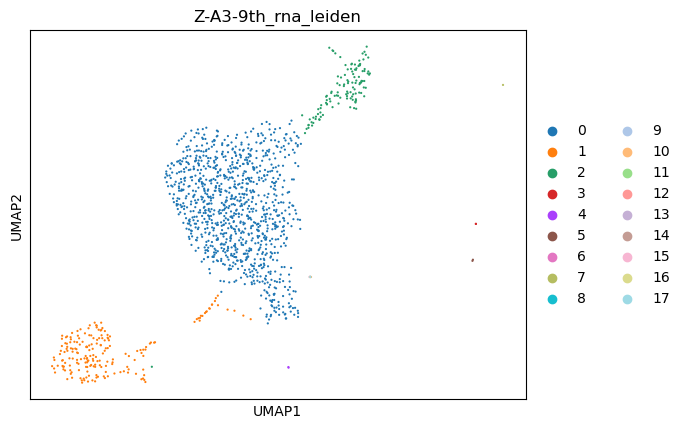

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


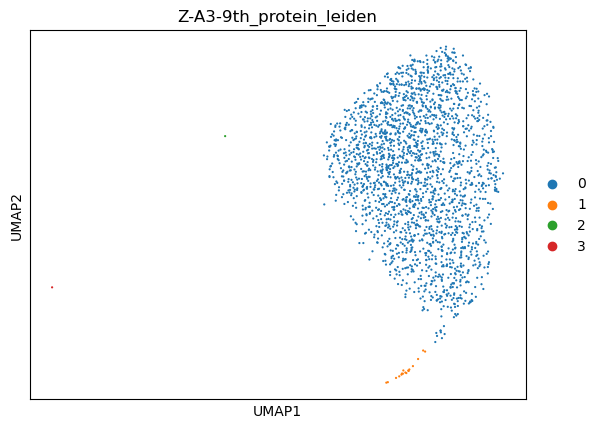

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


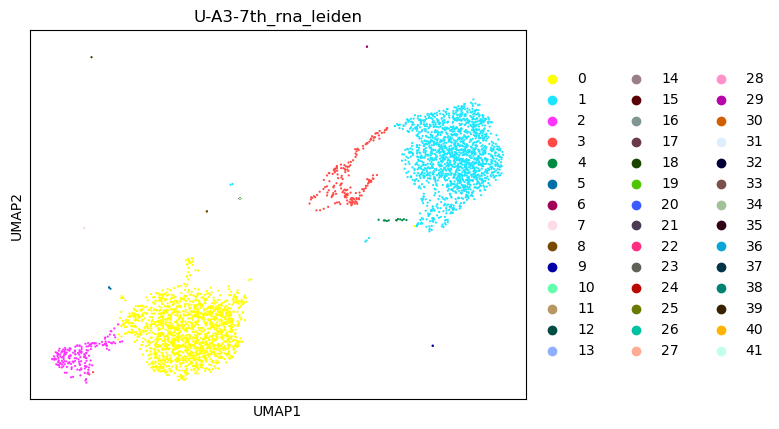

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


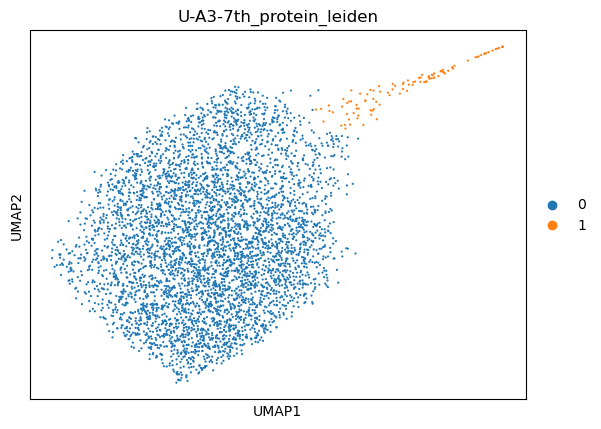

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


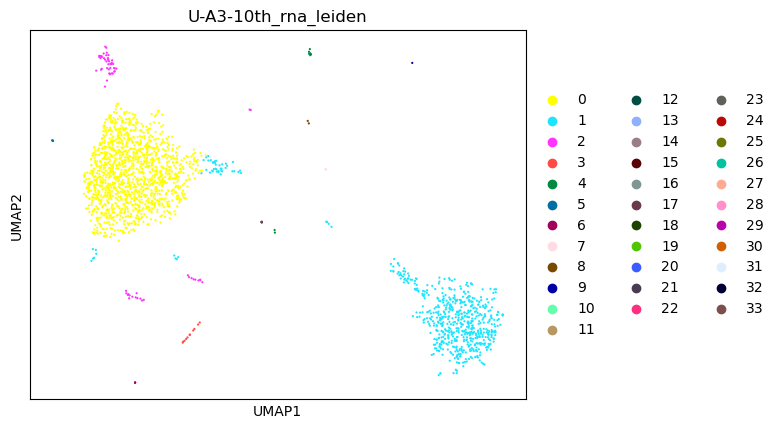

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


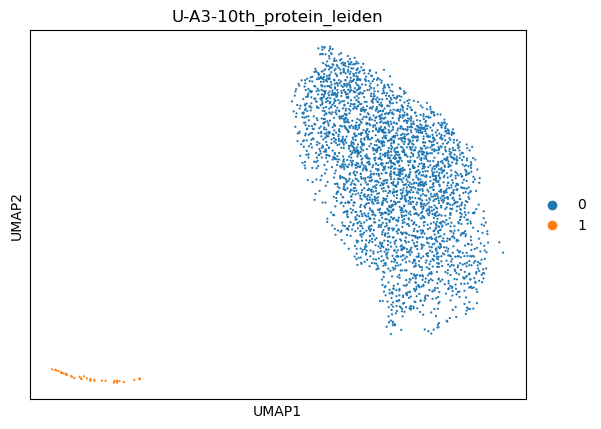

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


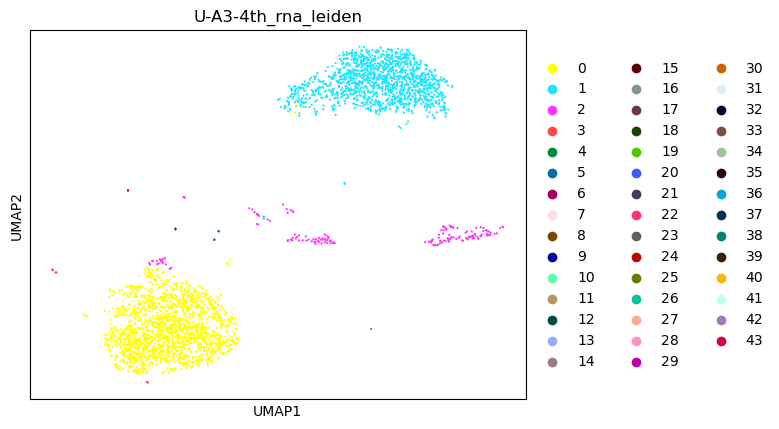

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


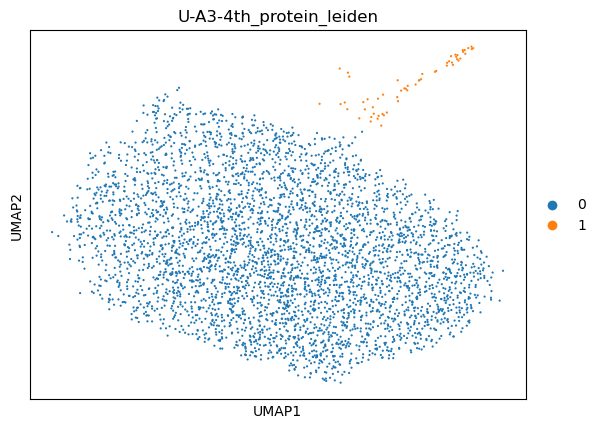

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


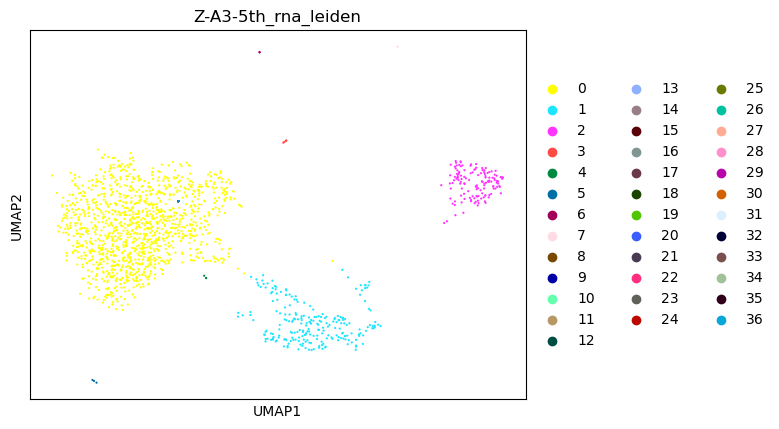

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


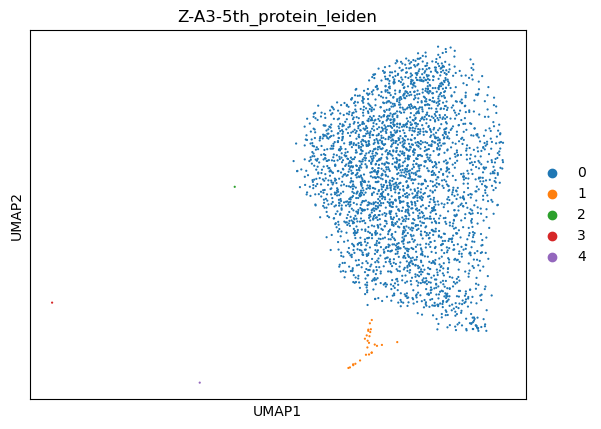

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


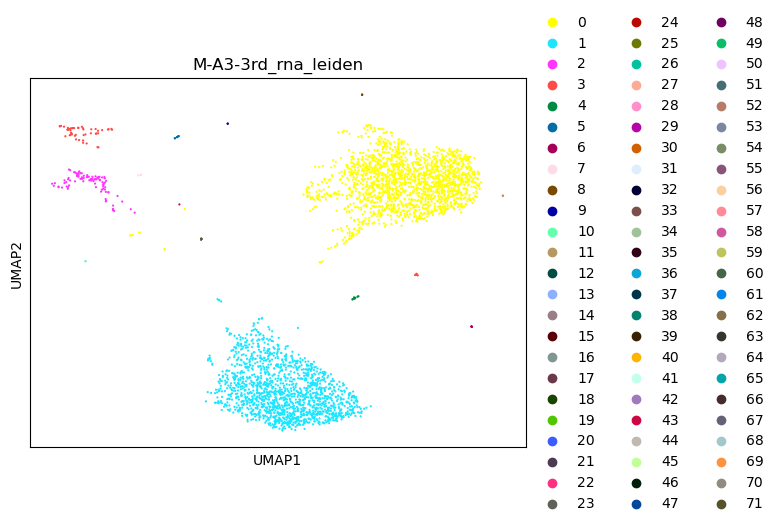

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


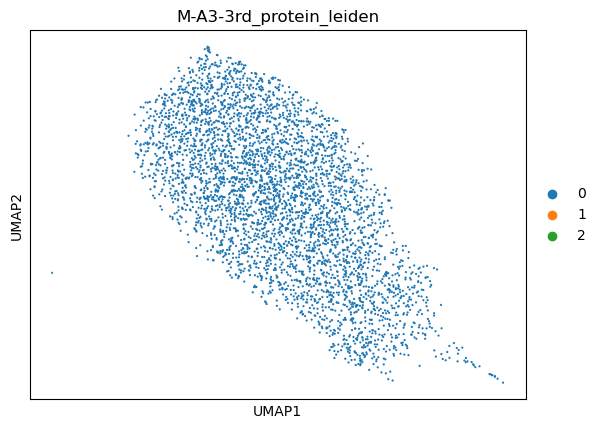

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


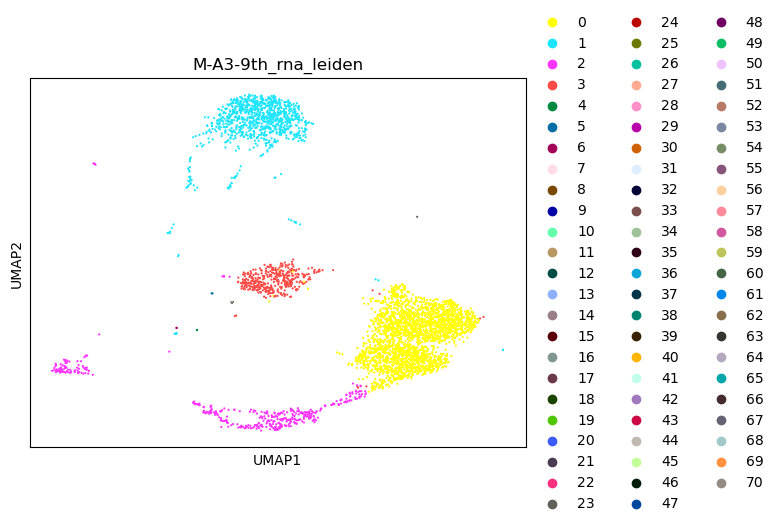

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


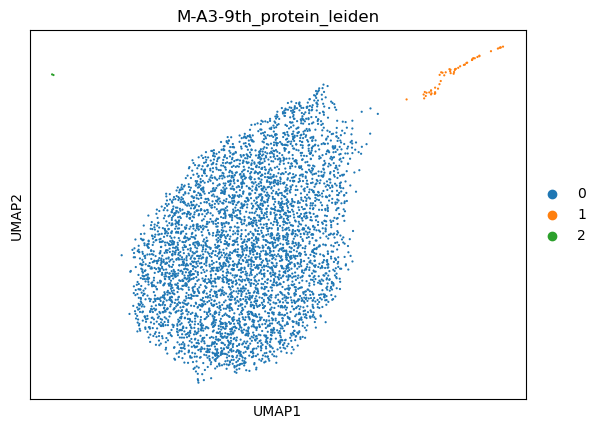

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


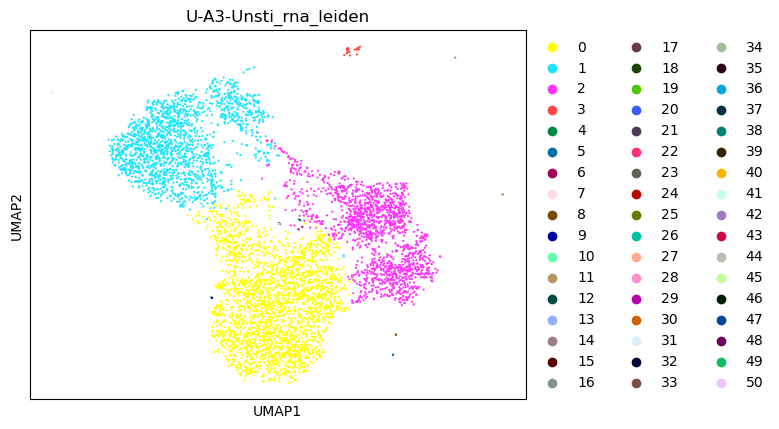

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


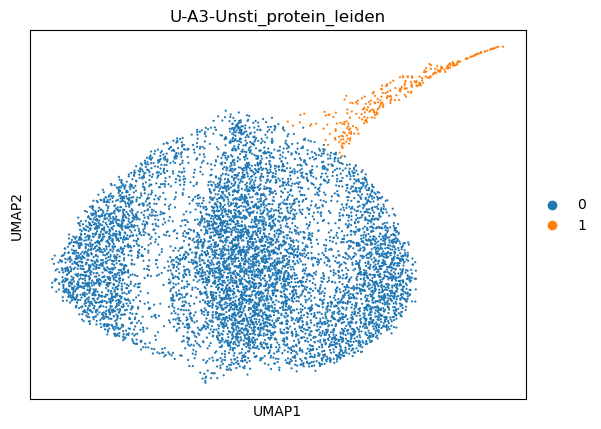

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


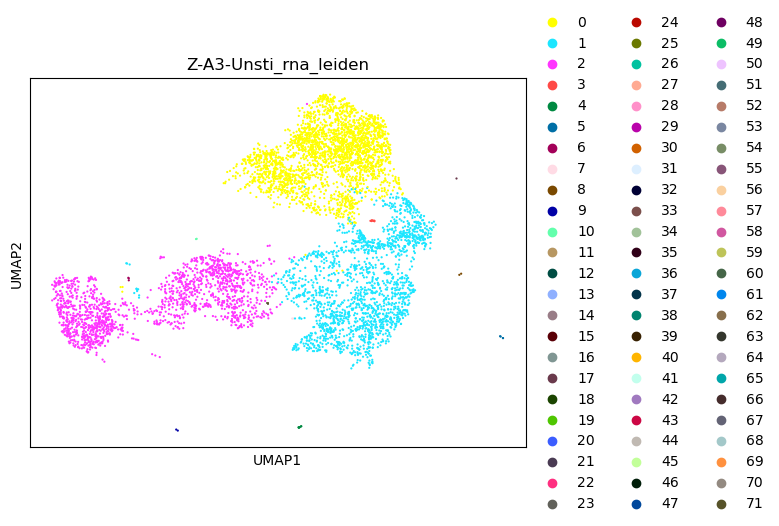

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


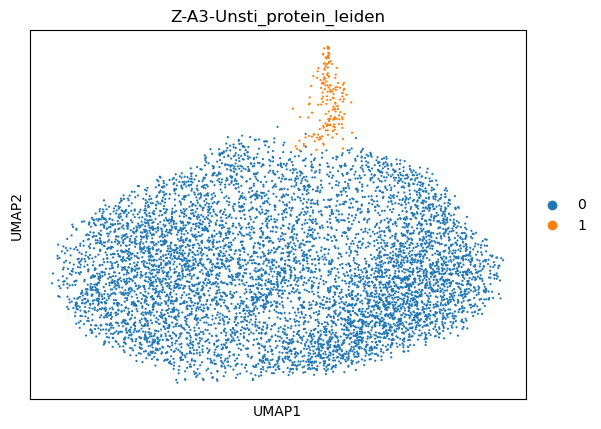

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


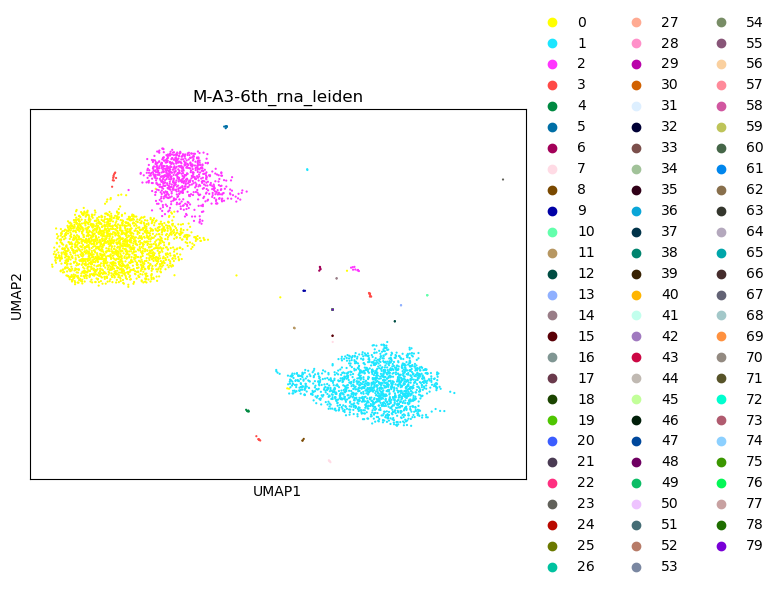

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


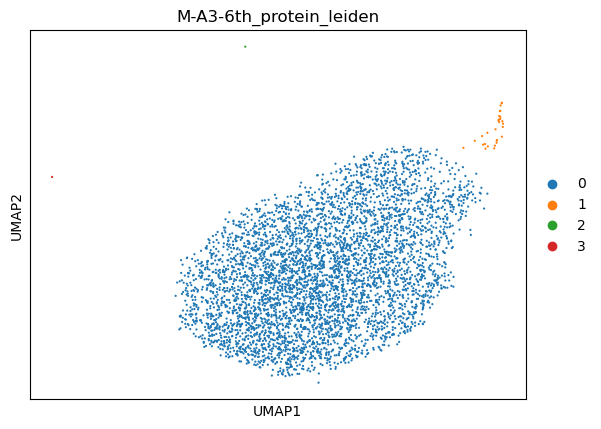

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


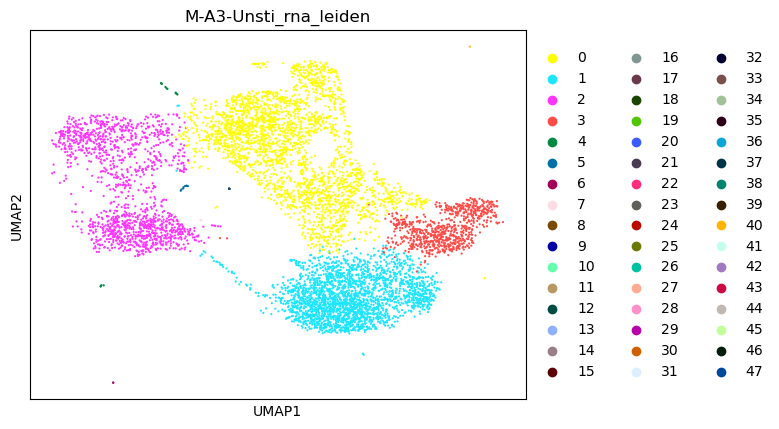

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


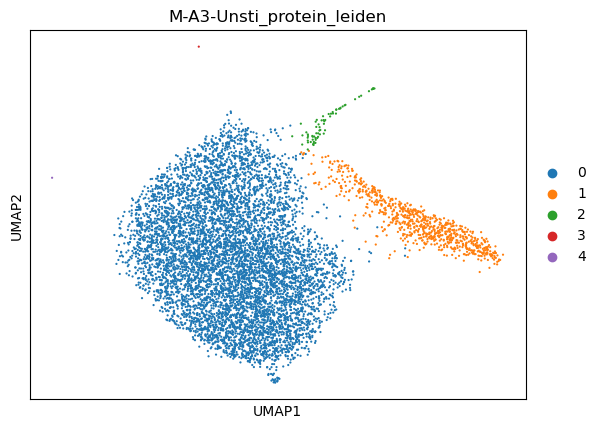

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


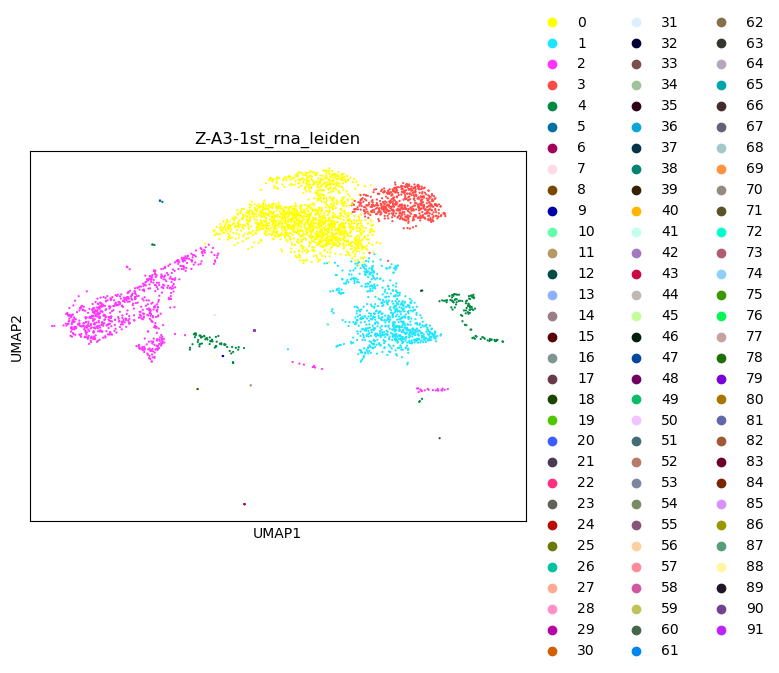

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


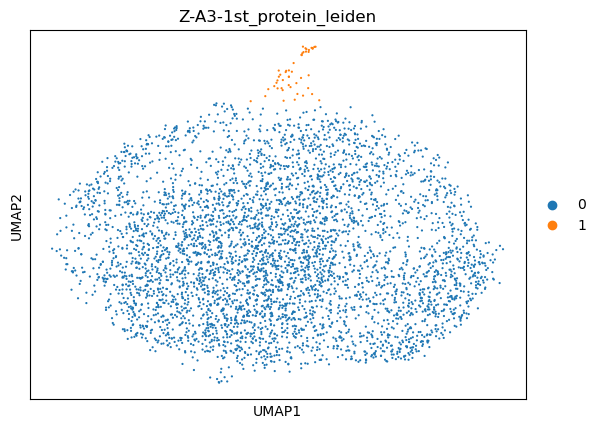

In [64]:
# make a umap for each donor at each timepoint
# make a umap for all timepoints for a donor
#thaws[1]
names = ["rna", "protein"]
for j in range(len(thaw_set)):
    for i in range(len(rna_prot)):
        sc.tl.umap(thaws[i][j][1])
        sc.tl.leiden(thaws[i][j][1], key_added=thaws[i][j][0] +"_"+names[i]+"_leiden", resolution=0.1)
        sc.pl.umap(thaws[i][j][1], color=thaws[i][j][0] +"_"+names[i]+"_leiden", size=10)

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


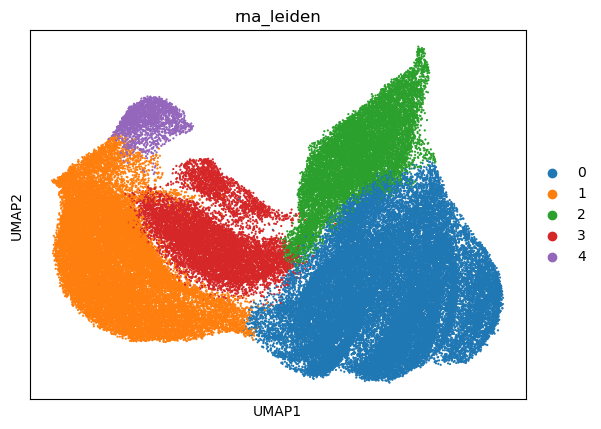

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


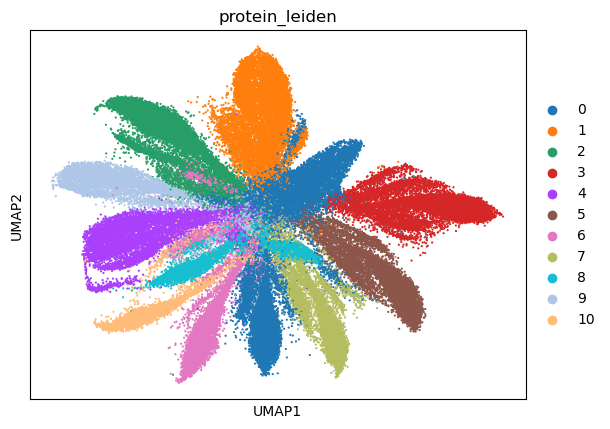

In [25]:
names = ["rna", "protein"]

for i in range(len(rna_prot)):
    sc.tl.umap(rna_prot[i])
    sc.tl.leiden(rna_prot[i], key_added=names[i]+"_leiden", resolution=0.1)
    sc.pl.umap(rna_prot[i], color=names[i]+"_leiden", size=10)

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


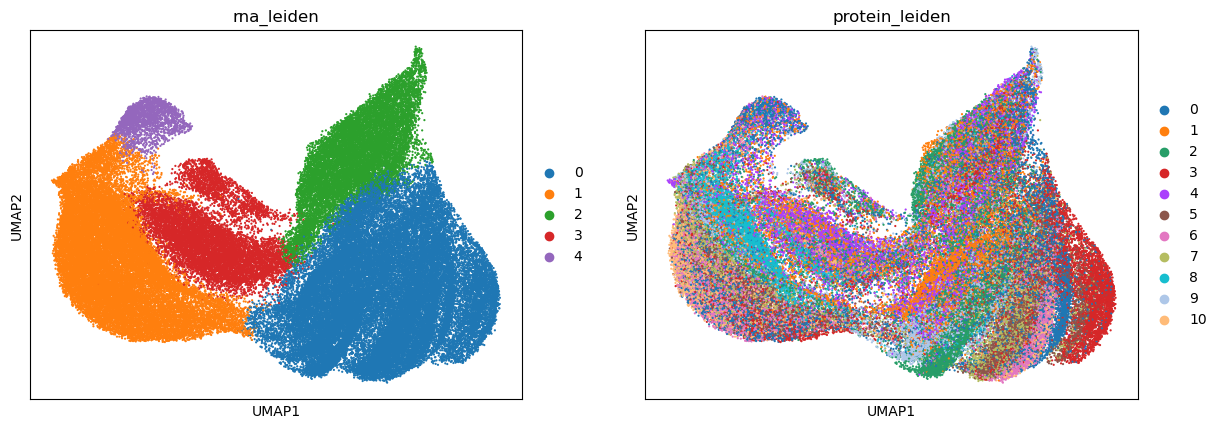

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


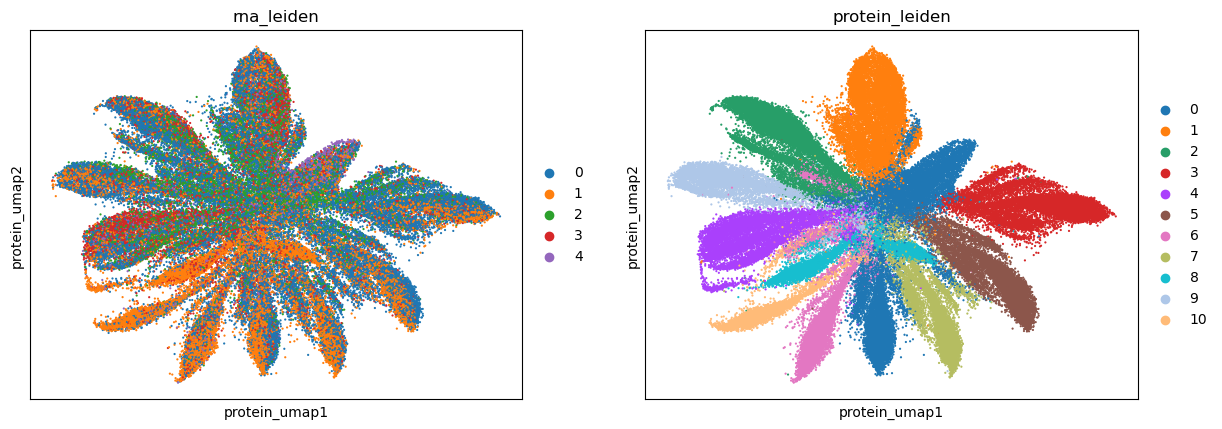

In [26]:
rna, protein = rna_prot

# If you want to show the difference in individual modality clustering
rna.obsm["protein"] = protein.to_df()
rna.obsm["protein_umap"] = protein.obsm["X_umap"]
rna.obs["protein_leiden"] = protein.obs["protein_leiden"]
rna.obsp["rna_connectivities"] = rna.obsp["connectivities"].copy()
protein.obsp["protein_connectivities"] = protein.obsp["connectivities"].copy()
rna.obsp["protein_connectivities"] = protein.obsp["protein_connectivities"]
sc.tl.umap(rna)
sc.pl.umap(rna, color=["rna_leiden", "protein_leiden"], size=10)
sc.pl.embedding(rna, basis="protein_umap", color=["rna_leiden", "protein_leiden"], size=10)

In [ ]:

for j in range(len(thaw_set)):
    mu.MuData({'rna': thaws[0][j][1], 'prot': thaws[1][j][1]})
    # Calculate weighted nearest neighbors
    mu.pp.neighbors(mdata, key_added='wnn')
    mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
    mu.pl.umap(mdata, color=[thaws[i][j][0] +'_rna:mod_weight', thaws[i][j][0] +'_prot:mod_weight'], cmap='RdBu')
    # actual joint clustering
    sc.tl.leiden(mdata, resolution=0.1, neighbors_key='wnn', key_added=thaws[i][j][0] +'_leiden_wnn') # 0.1 makes fewer clusters
    sc.pl.umap(mdata, color='leiden_wnn', legend_loc='on data')

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/pynndescent/pynndescent_.py:346: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/pynndescent/pynndescent_.py:348: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/pynndescent/pynndescent_.py:358: NumbaWarning: Cannot cache compiled function "process_candidates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  nn_descent_internal_low_memory_parallel(
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/pynndescent/pynndescent_.py:346: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses

In [ ]:
import muon as mu 

mdata = mu.MuData({'rna': rna_prot[0], 'prot': rna_prot[1]})
# Calculate weighted nearest neighbors
mu.pp.neighbors(mdata, key_added='wnn')
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
mu.pl.umap(mdata, color=['rna:mod_weight', 'prot:mod_weight'], cmap='RdBu')
# actual joint clustering?
sc.tl.leiden(mdata, resolution=0.1, neighbors_key='wnn', key_added='leiden_wnn') # 0.1 makes fewer clusters
sc.pl.umap(mdata, color='leiden_wnn', legend_loc='on data')

In [ ]:
# actual ranking stuff

labels = mdata.obs["leiden_wnn"] # here are the labels
rna = mdata["rna"] # normalized RNA counts
prot = mdata["prot"]
rna.obs["labels"] = labels
prot.obs["labels"] = labels
sc.tl.rank_genes_groups(rna, 'labels', method='wilcoxon', key_added = "wilcoxon") # wilcoxon rank sum, 'benjamini-hochberg' correction
# get top 3 genes
sc.pl.rank_genes_groups_heatmap(rna, n_genes=3, key="wilcoxon", groupby="labels", show_gene_labels=True)
# get top 3 prots
sc.tl.rank_genes_groups(prot, 'labels', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups_heatmap(prot, n_genes=3, key="wilcoxon", groupby="labels", show_gene_labels=True)

In [ ]:
rna_prot

In [ ]:
# make separate modality plots

In [ ]:
# want to cluster by donor, which is letter; then within donor, cluster by timepoint
# mapping to cell fate: ask George, Elisabeth (but with 3 prime CITEseq)
# also make an overall umap
# make a umap for each donor at each timepoint
# make a umap for all timepoints for a donor
# align to a database of possible cell fates last
# do separate clusters first, then get MM clusters
# do this with muon, do multimodal alignment with weighted nearest neighbors
# all should be T cells, panel of proteins should be depleted for PBMCs

In [ ]:
# make multimodal embeddings

In [ ]:
# want to cluster by donor, which is letter; then within donor, cluster by timepoint
# mapping to cell fate: ask George, Elisabeth (but with 3 prime CITEseq)
# also make an overall umap
# make a umap for each donor at each timepoint
# make a umap for all timepoints for a donor
# align to a database of possible cell fates last
# do separate clusters first, then get MM clusters
# do this with muon, do multimodal alignment with weighted nearest neighbors
# all should be T cells, panel of proteins should be depleted for PBMCs

In [ ]:
labels = mdata.obs["leiden_wnn"] # here are the labels
rna = mdata["rna"] # normalized RNA counts
prot = mdata["prot"]
rna.obs["labels"] = labels
prot.obs["labels"] = labels
sc.tl.rank_genes_groups(rna, 'labels', method='wilcoxon', key_added = "wilcoxon") # wilcoxon rank sum, 'benjamini-hochberg' correction
# get top 3 genes
sc.pl.rank_genes_groups_heatmap(rna, n_genes=3, key="wilcoxon", groupby="labels", show_gene_labels=True)
# get top 3 prots
sc.tl.rank_genes_groups(prot, 'labels', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups_heatmap(prot, n_genes=3, key="wilcoxon", groupby="labels", show_gene_labels=True)